### 177_semantic_segmentation_made_easy_using_segm_models

In [1]:

import segmentation_models as sm
from pathlib import Path
import glob
from tensorflow import keras
import random
import cv2
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

from smooth_tiled_predictions import predict_img_with_smooth_windowing

from simple_unet_model import simple_unet_model   #Use normal unet model
from keras.utils import normalize


from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

Segmentation Models: using `keras` framework.


In [2]:
# Now replace integer to RGB values to be used as labels.
#Find pixels with certain integer value for the above defined values...
#if matches then replace the value in that pixel with a specific RGB

def idx_to_rgb(label):
    
    water = 0
    ground = 1
    
    ground_RGB = np.array([255, 120, 0])
    water_RGB = np.array([0, 100, 255])
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label = np.expand_dims(label, axis=2)
    label_seg = np.zeros((label.shape[0],label.shape[1],3),dtype=np.uint8)
    label_seg [np.all(label==ground,axis=-1)] = ground_RGB
    label_seg [np.all(label==water,axis=-1)] = water_RGB
    
    return label_seg

In [98]:
image_directory = 'E:/Data/Image Segmentation Project/Beach Dataset/256_patches/images/'
mask_directory = 'E:/Data/Image Segmentation Project/Beach Dataset/256_patches/masks/'

In [99]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [100]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

In [6]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob(image_directory):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)

(53260, 256, 256, 3)


In [7]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(mask_directory):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_masks.shape)

(53260, 256, 256)


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(42608, 256, 256, 3)
(42608, 256, 256, 1)
(10652, 256, 256, 3)
(10652, 256, 256, 1)


In [14]:
x_val = x_val[0:500,:,:,:]
y_val = y_val[0:500,:,:,:]

In [16]:
del train_images
train_images = 0
del train_masks
train_masks = 0

In [17]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [18]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[sm.metrics.iou_score])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#print(model.summary())

In [19]:
history=model.fit(x_train, 
          y_train,
          batch_size=4, 
          epochs=20,
          verbose=1,
          validation_data=(x_val, y_val))

model.save('model weights/Landcover_weight.hdf5')

Epoch 1/20
10652/10652 [==============================] - 1103s 103ms/step - loss: 0.2558 - iou_score: 0.7692 - val_loss: 0.1195 - val_iou_score: 0.8152
Epoch 2/20
10652/10652 [==============================] - 1092s 103ms/step - loss: 0.1128 - iou_score: 0.8883 - val_loss: 0.2124 - val_iou_score: 0.7630
Epoch 3/20
10652/10652 [==============================] - 1086s 102ms/step - loss: 0.0792 - iou_score: 0.9151 - val_loss: 0.1203 - val_iou_score: 0.8164
Epoch 4/20
10652/10652 [==============================] - 1092s 103ms/step - loss: 0.0645 - iou_score: 0.9261 - val_loss: 0.1408 - val_iou_score: 0.7933
Epoch 5/20
10652/10652 [==============================] - 1090s 102ms/step - loss: 0.0566 - iou_score: 0.9306 - val_loss: 0.0858 - val_iou_score: 0.8616
Epoch 6/20
10652/10652 [==============================] - 1095s 103ms/step - loss: 0.0508 - iou_score: 0.9362 - val_loss: 0.0868 - val_iou_score: 0.8574
Epoch 7/20
10652/10652 [==============================] - 1094s 103ms/step - loss:

In [ ]:
#accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
model = keras.models.load_model('model weights/Landcover_weight.hdf5', compile=False)

In [107]:
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('Small patch prediction/patch_664.png', cv2.IMREAD_COLOR)       
#test_img = cv2.imread('Small patch prediction/20_10_19_North_Mustang_2_Flight_01_00002.JPG', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (256, 256))
#test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = preprocess_input(test_img)
test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)
prediction.shape

1/1 [==============================] - 0s 36ms/step


(1, 256, 256, 1)

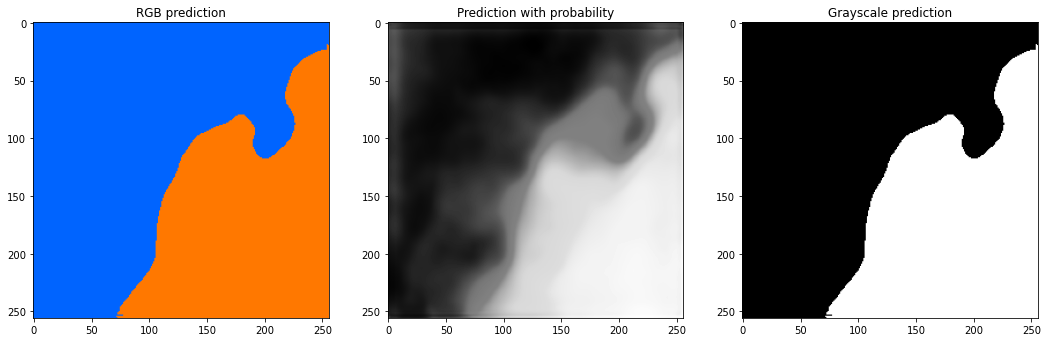

In [108]:
#View and Save segmented image
prediction_for_plot = prediction[0,:,:,0]
prediction_thresholded = (prediction_for_plot > 0.5).astype(np.uint8)
prediction_thresholded_RGB = idx_to_rgb(prediction_thresholded)

plt.figure(figsize=(18, 8))
plt.subplot(131)
plt.imshow(prediction_thresholded_RGB)
plt.title('RGB prediction')
plt.subplot(132)
plt.imshow(prediction_for_plot,cmap='gray')
plt.title('Prediction with probability')
plt.subplot(133)
plt.imshow(prediction_thresholded,cmap='gray') 
plt.title('Grayscale prediction')
plt.show()

#plt.imsave('Small patch prediction/patch_664_segmented.png', prediction_image, cmap='gray')

### 204_train_simple_unet_for_mitochondria

In [5]:
image_directory = 'E:/Data/Image Segmentation Project/Beach Dataset/256_patches/images/'
mask_directory = 'E:/Data/Image Segmentation Project/Beach Dataset/256_patches/masks/'

In [6]:
SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))
        
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number]) # shows color image as BGR
plt.subplot(122)
plt.imshow(mask_dataset[image_number], cmap='gray')
plt.show()

"""
In case we need to display image as RGB instead of BGR:
img = cv2.cvtColor(image_dataset[image_number], cv2.COLOR_BGR2RGB)
plt.imshow(img)
"""

In [8]:
#Normalize images

# in case input images are RGB
image_dataset = normalize(np.array(image_dataset), axis=-1)   # or 
#image_dataset = min_max_scaler.fit_transform(image_dataset)   # choose one

# in case input images are grayscale
#image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=-1),3)


#Do not normalize masks, just rescale to 0 to 1.

# in case input masks already have index values for different classes
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)

# in case input masks are grayscale between [0-255]
#mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

print("image_dataset shape: ", image_dataset.shape)
print("mask_dataset shape: ", mask_dataset.shape)

image_dataset shape:  (31000, 256, 256, 3)
mask_dataset shape:  (31000, 256, 256, 1)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256,3))) # RGB image is displayed as black because of normalization
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [14]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


#If starting with pre-trained weights. 
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')

history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=5, 
                    verbose=1,
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('model weights/Landcover_weight.hdf5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

C:\Users\mpashaei\.conda\envs\Test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


KeyboardInterrupt: 

15/15 [==============================] - 2s 76ms/step - loss: 0.2577 - accuracy: 0.8866
Accuracy =  88.65562677383423 %


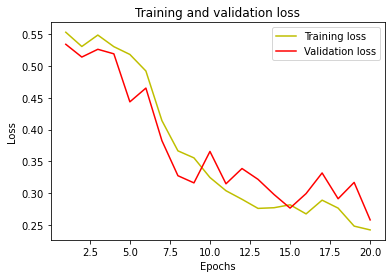

In [72]:
# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
#acc = history.history['accuracy']
val_acc = history.history['val_acc']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [73]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

15/15 [==============================] - 1s 75ms/step
IoU socre is:  0.624986347935742


In [ ]:
#Predict on a few images
model = get_model()
model.load_weights('model weights/Landcover_weight.hdf5') #Trained for 50 epochs and then additional 100

In [125]:
# Prediction on an image from test set

test_img_number = random.randint(0, len(X_test))
print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]  # if input image is RGB: test_img[:,:,:][:,:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.7).astype(np.uint8)

430
1/1 [==============================] - 0s 22ms/step


In [126]:
test_img_other = cv2.imread('Small patch prediction/patch_664.png', 1)
test_img_other_norm = normalize(np.array(test_img_other), axis=-1)# or test_img_other_norm = min_max_scaler.fit_transform(test_img_other_norm)
#test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.7).astype(np.uint8)

1/1 [==============================] - 0s 33ms/step


In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other)
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

## Multi-Class Segmentation for Binary Prediction 

In [3]:
# Now replace integer to RGB values to be used as labels.
#Find pixels with certain integer value for the above defined values...
#if matches then replace the value in that pixel with a specific RGB

def idx_to_rgb(label):
    
    water = 0
    ground = 1
    
    ground_RGB = np.array([255, 120, 0])
    water_RGB = np.array([0, 100, 255])
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label = np.expand_dims(label, axis=2)
    label_seg = np.zeros((label.shape[0],label.shape[1],3),dtype=np.uint8)
    label_seg [np.all(label==ground,axis=-1)] = ground_RGB
    label_seg [np.all(label==water,axis=-1)] = water_RGB
    
    return label_seg

In [106]:
root_directory = 'E:/Data/Image Segmentation Project/Beach Dataset/'

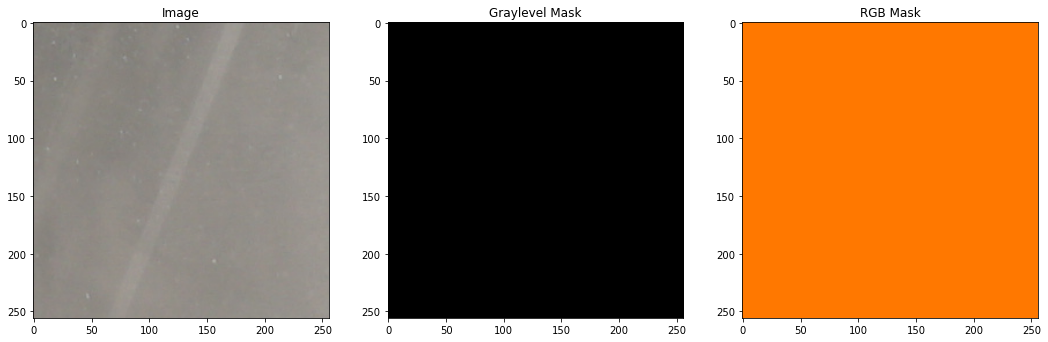

labels are:  [1]  and the counts are:  [65536]


In [13]:
train_img_dir = root_directory + "256_patches/data_for_training_and_testing/train_images/train/"
train_mask_dir = root_directory + "256_patches/data_for_training_and_testing/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0, num_images-1)
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot,cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(train_mask_dir+msk_list[img_num], 0) # 0 because masks are greylevel images


# We can convert greylevel masks back to RGB
mask_for_plot_rgb = idx_to_rgb(mask_for_plot)

plt.figure(figsize=(18, 8))
plt.subplot(131)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(132)
plt.imshow(mask_for_plot,cmap='gray')  # for graylevel mask images: plt.imshow(mask_for_plot, cmap='gray')
plt.title('Graylevel Mask')
plt.subplot(133)
plt.imshow(mask_for_plot_rgb)  # for graylevel mask images: plt.imshow(mask_for_plot, cmap='gray')
plt.title('RGB Mask')
plt.show()

labels, count = np.unique(mask_for_plot, return_counts = True)
print("labels are: ", labels, " and the counts are: ", count)

#cv2.imwrite("C:/Users/mpashaei/Desktop/Test.jpg", mask_for_plot)

In [107]:
# Define Generator for images and masks so we can read them directly from the drive. 

seed = 24
num_class = 2
batch_size = 64

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
scaler = MinMaxScaler()
labelencoder = LabelEncoder()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    #img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    # Just for multi-class case
    #mask = to_categorical(mask, num_class)  # **************************

    return (img,mask)

#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=False,
                      vertical_flip=False,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        #target_size=(patch_size, patch_size),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        #target_size=(patch_size, patch_size),
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [108]:
train_img_path = root_directory + "256_patches/data_for_training_and_testing/train_images/"
train_mask_path = root_directory + "256_patches/data_for_training_and_testing/train_masks/"

train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=num_class)

val_img_path = root_directory + "256_patches/data_for_training_and_testing/val_images/"
val_mask_path = root_directory + "256_patches/data_for_training_and_testing/val_masks/"

val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=num_class)

In [109]:
num_train_imgs = len(os.listdir(train_img_path+'train/'))
num_val_images = len(os.listdir(val_img_path+'val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3

In [110]:
BACKBONE = 'resnet34'
#BACKBONE = 'inceptionv3'
#BACKBONE = 'vgg16'

In [111]:
# Learning rate scheduler

learning_rate = 1e-4

def lr_scheduler(epoch,lr):
    decay_step = 10
    if epoch < 10:
        return lr
    elif (epoch % decay_step) == 0:
        return lr * tf.math.exp(-0.01*epoch/10)
    else:
        return lr

# Model Callbacks
checkpoint_filepath = './checkpoint/Landcover_weight_ResNet34_backbone_50epochs.hdf5'

callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss',save_weights_only=True, save_best_only=True, mode='max'),
             tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

optim = keras.optimizers.Adam(learning_rate=learning_rate)

In [112]:
# Define the model
'''
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=num_class, activation='softmax')
'''

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[sm.metrics.iou_score])

print(model.summary())
print(model.input_shape)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_272 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                         

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_129[0][0]']                
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_278 (ZeroPaddin  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 g2D)                           64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_131[0][0]']                
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_132[0][0]']                
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_284 (ZeroPaddin  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 g2D)                           128)                                                              
          

 add_135 (Add)                  (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_135[0][0]']                
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_290 (ZeroPaddin  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 g2D)     

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_138[0][0]']                
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_296 (ZeroPaddin  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 g2D)                           256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_141[0][0]']                
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_302 (ZeroPaddin  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 g2D)                           512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [92]:
from focal_loss import BinaryFocalLoss

#model.compile(optimizer=optim, loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
#model.compile(optimizer=optim, loss='binary_crossentropy', metrics=[sm.metrics.iou_score])

In [113]:
history=model.fit(train_img_gen,
                  steps_per_epoch=steps_per_epoch,
                   #batch_size=2,
                   epochs=10,
                   verbose=1,
                   validation_data=val_img_gen,
                   validation_steps=val_steps_per_epoch,
                   #validation_split=0.1,
                   callbacks=callbacks)

model.save('model weights/Landcover_weight.hdf5')

Found 45511 images belonging to 1 classes.
Found 45511 images belonging to 1 classes.
Epoch 1/10
711/711 [==============================] - ETA: 0s - loss: 0.0492 - iou_score: 0.9457Found 7750 images belonging to 1 classes.
Found 7750 images belonging to 1 classes.
711/711 [==============================] - 1541s 2s/step - loss: 0.0492 - iou_score: 0.9457 - val_loss: 0.2583 - val_iou_score: 0.7990 - lr: 0.0010
Epoch 2/10
711/711 [==============================] - 746s 1s/step - loss: 0.0283 - iou_score: 0.9699 - val_loss: 0.1208 - val_iou_score: 0.9159 - lr: 0.0010
Epoch 3/10
711/711 [==============================] - 692s 974ms/step - loss: 0.0189 - iou_score: 0.9798 - val_loss: 0.0265 - val_iou_score: 0.9699 - lr: 0.0010
Epoch 4/10
711/711 [==============================] - 729s 1s/step - loss: 0.0192 - iou_score: 0.9797 - val_loss: 0.0304 - val_iou_score: 0.9726 - lr: 0.0010
Epoch 5/10
711/711 [==============================] - 785s 1s/step - loss: 0.0186 - iou_score: 0.9809 - val_l

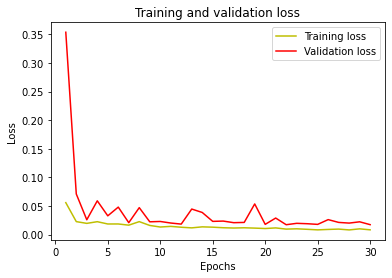

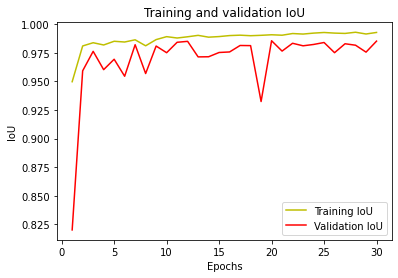

In [94]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('Training_validation_loss.png')

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()
#plt.savefig('Training_validation_IoU.png')

In [114]:
root_directory = "C:/Users/mpashaei/Desktop/Image Segmentation Project/semantic_segmentation_of_aerial_imagery_using_unet"

In [115]:
BACKBONE = 'resnet34'
patch_size = 256
n_classes = 1

#from sklearn import preprocessing
#scaler = preprocessing.MinMaxScaler()
#preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
with tf.device('/gpu:0'):
    #model = load_model('model weights/res34_backbone_50epochs.hdf5', compile=False)
    #model2 = load_model('saved_models/inceptionv3_backbone_50epochs.hdf5', compile=False)
    model = load_model('model weights/Landcover_weight.hdf5', compile=False)

In [118]:
def predict_with_smooth(input_img, patch_size):
    
    #input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    #input_img = preprocess_input(input_img)
    
    print(input_img.shape)

    # Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
    # Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
    predictions_smooth = predict_img_with_smooth_windowing(
        input_img,
        window_size=patch_size,
        subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
        nb_classes=n_classes,
        pred_func=(
            lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
    )

    #final_prediction = (predictions_smooth[:,:,0] > 0.5).astype(np.uint8) # For binary classification
    final_prediction = np.argmax(predictions_smooth, axis=2)  # For multi-class classification
    print("final_prediction.shape = ", final_prediction.shape)
    return final_prediction

In [119]:
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'Large Images Prediction':   #Find all 'images' directories
        images = os.listdir(path+'/images/')  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".JPG"):   #Only read jpg images...
                name = Path(image_name).stem
                img = cv2.imread(path+"/images/"+image_name, cv2.IMREAD_COLOR)  #Read each image as BGR
                                                                 # No need for conversion to RGB
                                                                 # model has been trainded on BGR    
                prediction = predict_with_smooth(img, patch_size)
                
                prediction_BGR = idx_to_rgb(prediction)
                cv2.imwrite(path + '/predictions/RGB/' + name + '_mask.png', cv2.cvtColor(prediction_BGR,cv2.COLOR_BGR2RGB))
                cv2.imwrite(path + '/predictions/Gray/' + name + '_mask.png', prediction)

(5304, 7952, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

83/83 [==============================] - 9s 110ms/step


 12%|█▎        | 1/8 [00:18<02:12, 18.88s/it]

83/83 [==============================] - 9s 111ms/step


 25%|██▌       | 2/8 [00:39<01:57, 19.64s/it]

83/83 [==============================] - 9s 110ms/step


 38%|███▊      | 3/8 [00:58<01:38, 19.75s/it]

83/83 [==============================] - 9s 110ms/step


 50%|█████     | 4/8 [01:19<01:19, 19.99s/it]

83/83 [==============================] - 9s 111ms/step


 62%|██████▎   | 5/8 [01:38<00:59, 19.73s/it]

83/83 [==============================] - 9s 111ms/step


 75%|███████▌  | 6/8 [01:59<00:39, 19.98s/it]

83/83 [==============================] - 9s 112ms/step


 88%|████████▊ | 7/8 [02:19<00:20, 20.08s/it]

83/83 [==============================] - 9s 111ms/step


100%|██████████| 8/8 [02:40<00:00, 20.02s/it]


final_prediction.shape =  (5304, 7952)
(5304, 7952, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

83/83 [==============================] - 9s 111ms/step


 12%|█▎        | 1/8 [00:18<02:11, 18.78s/it]

83/83 [==============================] - 9s 107ms/step


 25%|██▌       | 2/8 [00:38<01:56, 19.49s/it]

83/83 [==============================] - 9s 110ms/step


 25%|██▌       | 2/8 [00:53<02:39, 26.62s/it]


KeyboardInterrupt: 

## Apply on MATLAB-derived image patches

In [91]:
root_directory = "E:/Data/Image Segmentation Project/Beach Dataset/Matlab_Patches/images/"
output_directory = "E:/Data/Image Segmentation Project/Beach Dataset/Matlab_Patches/predictions/"

In [93]:
for root, dirs, files in os.walk(root_directory, topdown=False):
    for directory in dirs:
        print("=======================")
        #print (os.path.join(root, directory))
        for filename in glob.glob(os.path.join(root, directory)+'/*.JPG'): #assuming gif
            #print(filename)
            #filepath, name = os.path.split(filename)
            img = cv2.imread(filename, cv2.IMREAD_COLOR)
            #img = cv2.resize(img, (SIZE_Y, SIZE_X))
            #img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
            img = preprocess_input(img)
            img = np.expand_dims(img, axis=0)
            prediction = model.predict(img)
            prediction = (prediction > 0.5).astype(np.uint8)
            print(prediction.shape)
            #prediction = np.argmax(prediction, axis=3) 
            #prediction = np.reshape(prediction, (prediction.shape[1], prediction.shape[2]))
            #print(prediction.shape)
            print(prediction.shape)
            prediction = idx_to_rgb(prediction[0,:,:,0])
            print(prediction.shape)
            
            name = filename.split(os.sep)[-1]
            name = os.path.splitext(name)[0]
            print(name)
            #cv2.imwrite(output_directory + directory + '/' + name + '.png', prediction[0,:,:,0])
            cv2.imwrite(output_directory + directory + '/' + name + '.png', cv2.cvtColor(prediction,cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 34ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_1
1/1 [==============================] - 0s 32ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_10
1/1 [==============================] - 0s 39ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_100
1/1 [==============================] - 0s 63ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_101
1/1 [==============================] - 0s 31ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_102
1/1 [==============================] - 0s 30ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_103
1/1 [==============================] - 0s 33ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_104
1/1 [==============================] - 0s 45ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_105
1/1 [==============================] - 0s 33ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_106
1/1 [========

1/1 [==============================] - 0s 29ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_62
1/1 [==============================] - 0s 27ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_63
1/1 [==============================] - 0s 38ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_64
1/1 [==============================] - 0s 32ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_65
1/1 [==============================] - 0s 28ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_66
1/1 [==============================] - 0s 43ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_67
1/1 [==============================] - 0s 37ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_68
1/1 [==============================] - 0s 29ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_69
1/1 [==============================] - 0s 29ms/step
(1, 256, 256, 1)
(1, 256, 256, 1)
(256, 256, 3)
patch_7
1/1 [===============